# Homework - Trees

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from tqdm.auto import trange
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

# %pip install xgboost
import xgboost as xgb

## Getting the data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Preprocessing

In [5]:
data.fillna(0, inplace=True)
df_full_train, df_test = train_test_split(data, test_size=.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=.25, random_state=1)

y_train = np.log1p(df_train["median_house_value"])
y_valid = np.log1p(df_valid["median_house_value"])

vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(df_train.drop("median_house_value", axis=1).to_dict(orient="records"))
X_valid = vec.transform(df_valid.drop("median_house_value", axis=1).to_dict(orient="records"))

## Question 1
Let's train a decision tree regressor to predict the `median_house_value` variable.

- Train a model with `max_depth=1`.

Which feature is used for splitting the data?

- `ocean_proximity=INLAND`
- `total_rooms`
- `latitude`
- `population`

In [6]:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

print(export_text(model, feature_names=vec.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Question 2
Train a random forest model with these parameters:

- `n_estimators=10`
- `random_state=1`
- `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on validation?

- 0.05
- 0.25
- 0.55
- 0.85

In [7]:
model2 = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

model2.fit(X_train, y_train)
y_pred = model2.predict(X_valid)

print(mean_squared_error(y_valid, y_pred, squared=True))

0.06034889885906303


## Question 3
Now let's experiment with the `n_estimators` parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to `1`.
- Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving?

- 10
- 55
- 75
- 150

In [8]:
def train(X_train, X_test, y_train, y_test):
    scores = {}
    for e in trange(10, 201, 10, desc="Choosing n_estimators"):
        model = RandomForestRegressor(n_estimators=e, random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=True)
        scores[e] = rmse
    
    return scores

Choosing n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

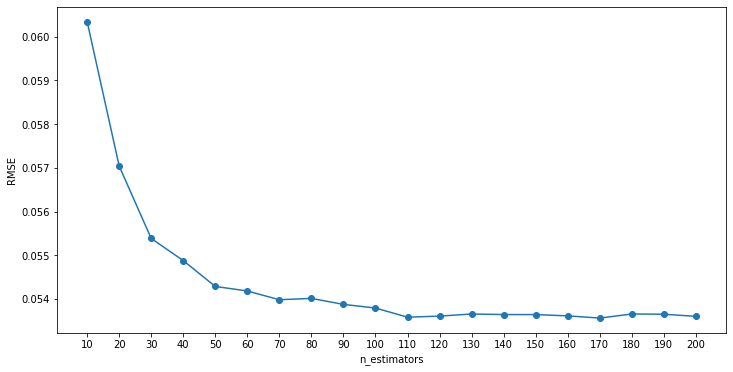

In [9]:
results = train(X_train, X_valid, y_train, y_valid)

plt.figure(figsize=(12, 6))
plt.plot(results.keys(), results.values())
plt.scatter(results.keys(), results.values())
plt.xlabel("n_estimators")
plt.xticks(list(range(10, 201, 10)))
plt.ylabel("RMSE")
plt.show()

## Question 4
Let's select the best `max_depth`:

- Try different values of `max_depth`: `[10, 15, 20, 25]`
- For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
- Fix the random seed: `random_state=1`

What's the best `max_depth`:

- 10
- 15
- 20
- 25

In [10]:
def train_robust(X_train, X_test, y_train, y_test):
    max_depths = []
    n_estimators = []
    scores = []
    
    for d in trange(10, 26, 5, desc="max_depth"):
        for n in trange(10, 201, 10, desc="n_estimators", leave=False):
            model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = mean_squared_error(y_test, y_pred, squared=True)
            
            max_depths.append(d)
            n_estimators.append(n)
            scores.append(rmse)
            
    return pd.DataFrame({
        "max_depth": max_depths,
        "n_estimators": n_estimators,
        "rmse": scores
    })

In [11]:
scores = train_robust(X_train, X_valid, y_train, y_valid)

max_depth:   0%|          | 0/4 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
scores.groupby("max_depth").min()["rmse"]

max_depth
10    0.061956
15    0.054398
20    0.053690
25    0.053516
Name: rmse, dtype: float64

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

- Train the model with these parametes:
  - `n_estimators=10`,
  - `max_depth=20`,
  - `random_state=1`,
  - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the most important feature?

- `total_rooms`
- `median_income`
- `total_bedrooms`
- `longitude`

In [13]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
model.fit(X_train, y_train)

df_estimators = []
for i in range(len(model.estimators_)):
    df_estimators.append(model.estimators_[i].feature_importances_)

pd.DataFrame(df_estimators, columns=vec.feature_names_).describe().loc["mean"].sort_values()

ocean_proximity=ISLAND        0.000357
ocean_proximity=NEAR BAY      0.000480
ocean_proximity=<1H OCEAN     0.002489
ocean_proximity=NEAR OCEAN    0.004699
households                    0.016387
total_bedrooms                0.019172
total_rooms                   0.020541
population                    0.030777
housing_median_age            0.033145
longitude                     0.096470
latitude                      0.101256
ocean_proximity=INLAND        0.310901
median_income                 0.363326
Name: mean, dtype: float64

## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:
```python
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta first to 0.1 and then to 0.01

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both gives same

In [14]:
def train_xgboost(X_train, X_test, y_train, y_test, feature_names, eta):

    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': "reg:squarederror",
        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }

    d_train = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
    d_test = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

    model = xgb.train(xgb_params, d_train, num_boost_round=100)
    y_pred = model.predict(d_test)

    return mean_squared_error(y_test, y_pred, squared=True)


In [15]:
features = vec.get_feature_names()
features[5] = "ocean_proximity=less_than1H OCEAN"

for eta in [0.3, 0.1, 0.01]:
    score = train_xgboost(X_train, X_valid, y_train, y_valid, features, eta=eta)
    print(f"eta = {eta} -> rmse = {score}")
    

eta = 0.3 -> rmse = 0.05111930390108557
eta = 0.1 -> rmse = 0.05314943034462633
eta = 0.01 -> rmse = 18.189893628482622
